## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- сравнить с точностью полносвязной сети для этой выборки

In [113]:
from __future__ import print_function
#import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np

In [114]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

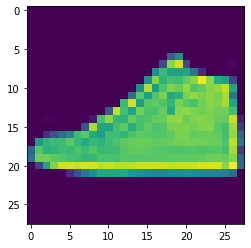

In [115]:
plt.imshow(x_train[1501,:,:])
plt.show()

In [116]:
param_dict = dict()

In [117]:
param_dict.update({'num_pixels': len(x_train[1501][0])})
print(f'Количество пикселей {param_dict["num_pixels"]}')

Количество пикселей 28


In [118]:
# Кол-во классов
classes = set(y_train)
param_dict['num_classes'] = len(classes)
print(f'Кол-во классов {param_dict["num_classes"]} - {classes}')

Кол-во классов 10 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [119]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the images.
x_train /= 255 
x_test /= 255 

# изменение размерности в 4х мерный массив
# т.к. в двухмерную сверточную модель надо передать 4х мерный тензор
x_train = x_train.reshape(x_train.shape[0], 
                          param_dict["num_pixels"],
                          param_dict["num_pixels"],
                          1)
x_test = x_test.reshape(x_test.shape[0], 
                        param_dict["num_pixels"],
                        param_dict["num_pixels"],
                        1)

y_train = to_categorical(y_train, param_dict['num_classes'])
y_test = to_categorical(y_test, param_dict['num_classes'])

In [120]:
param_dict['batch_size'] = 32
param_dict['num_classes']  = 10
param_dict['epochs']  = 5
param_dict['data_augmentation']  = False
param_dict['add_layer'] = False
param_dict['num_predictions']  = 20
param_dict['num_convolution_kernels'] = 28
param_dict['verbose'] = 1

param_dict['x_train'] = x_train 
param_dict['x_test'] = x_test

param_dict['y_train'] = y_train
param_dict['y_test'] = y_test

In [107]:
def create_fit_model(param_dict):
  # конфигурирование слоев нейросети
  model = Sequential()

  # слои нейросети отвественные за свертку и max-pooling
  model.add(Conv2D(param_dict['num_classes'], (3,3), padding='same',
                   input_shape=x_train.shape[1:]))

  # 1
  model.add(Activation('relu'))
  model.add(Conv2D(param_dict['num_convolution_kernels'], 
                   (3,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  # 2
  model.add(Conv2D(param_dict['num_convolution_kernels']*2,
                   (3, 3),
                   padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(param_dict['num_convolution_kernels']*2,
                   (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # 3
  if param_dict['add_layer']:
    model.add(Conv2D(param_dict['num_convolution_kernels']*2,
                   (3, 3),
                   padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(param_dict['num_convolution_kernels']*2,
                    (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))  

  # полносвязные слои нейронной сети
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(param_dict['num_classes']))
  model.add(Activation('softmax'))

  # инициализация RMSprop optimizer
  #opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # компиляция модели
  model.compile(loss='categorical_crossentropy',
                optimizer='SGD',
                metrics=['accuracy'])

  if not param_dict['data_augmentation']:
      print('Не используется data augmentation')
      history = model.fit(param_dict['x_train'], 
                param_dict['y_train'],
                batch_size=param_dict['batch_size'],
                epochs=param_dict['epochs'],
                validation_data=(param_dict['x_test'], 
                                 param_dict['y_test']),
                shuffle=True,
                verbose=param_dict['verbose'])
  else:
      print('Использование data augmentation в реальном времени')
      # Препроцессинг и data augmentation в реальном времени:
      datagen = ImageDataGenerator(
          featurewise_center=False,
          samplewise_center=False,
          featurewise_std_normalization=False,
          samplewise_std_normalization=False,
          zca_whitening=False, 
          zca_epsilon=1e-06, 
          rotation_range=0, 
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0., 
          zoom_range=0., 
          channel_shift_range=0.,
          fill_mode='nearest',
          cval=0.,
          horizontal_flip=True,
          vertical_flip=False,
          rescale=None,
          preprocessing_function=None,
          data_format=None,
          validation_split=0.0)

      # запуск data augmentation через fit
      #datagen.fit(x_train)

      # запуск data augmentation через fit_generator
      history = model.fit_generator(datagen.flow(
          param_dict['x_train'], 
          param_dict['y_train'],
          batch_size=param_dict['batch_size']),
                          epochs=param_dict['epochs'],
                          validation_data=(param_dict['x_test'], 
                                           param_dict['y_test']),
                          workers=4)
  # проверка работы обученной модели
  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  return model, history    

Не используется data augmentation
Epoch 1/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.9969 - accuracy: 0.6271 - val_loss: 0.5898 - val_accuracy: 0.7769
Epoch 2/5
1875/1875 [==============================] - 151s 80ms/step - loss: 0.6135 - accuracy: 0.7679 - val_loss: 0.5187 - val_accuracy: 0.8035
Epoch 3/5
1875/1875 [==============================] - 150s 80ms/step - loss: 0.5308 - accuracy: 0.8018 - val_loss: 0.4504 - val_accuracy: 0.8325
Epoch 4/5
1875/1875 [==============================] - 150s 80ms/step - loss: 0.4875 - accuracy: 0.8193 - val_loss: 0.4202 - val_accuracy: 0.8494
Epoch 5/5
313/313 [==============================] - 7s 22ms/step - loss: 0.3980 - accuracy: 0.8560
Test loss: 0.3980177044868469
Test accuracy: 0.8560000061988831


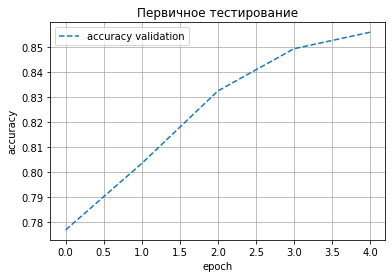

In [108]:
model, history = create_fit_model(param_dict)

plt.plot(history.history['val_accuracy'], '--', label = f'accuracy validation')
plt.legend()
plt.grid('On')
plt.title('Первичное тестирование')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [109]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 28, 28, 10)        100       
_________________________________________________________________
activation_78 (Activation)   (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 26, 26, 28)        2548      
_________________________________________________________________
activation_79 (Activation)   (None, 26, 26, 28)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 28)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 13, 13, 56)      

####Оценить рост точности при увеличении ширины сети (больше ядер)

Не используется data augmentation
Epoch 1/5
1875/1875 [==============================] - 54s 28ms/step - loss: 1.8285 - accuracy: 0.3603 - val_loss: 0.8020 - val_accuracy: 0.7209
Epoch 2/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.9152 - accuracy: 0.6761 - val_loss: 0.6772 - val_accuracy: 0.7540
Epoch 3/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.7961 - accuracy: 0.7114 - val_loss: 0.6442 - val_accuracy: 0.7668
Epoch 4/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.7469 - accuracy: 0.7240 - val_loss: 0.5994 - val_accuracy: 0.7800
Epoch 5/5
313/313 [==============================] - 3s 10ms/step - loss: 0.5933 - accuracy: 0.7889
Test loss: 0.5932905077934265
Test accuracy: 0.7889000177383423
Не используется data augmentation
Epoch 1/5
1875/1875 [==============================] - 100s 53ms/step - loss: 1.0571 - accuracy: 0.6029 - val_loss: 0.6098 - val_accuracy: 0.7747
Epoch 2/5
1875/1875 [=====================

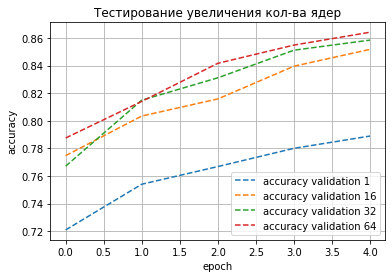

In [111]:
list_num_convolution_kernels = [1, 16, 32, 64]
for num_convolution_kernels in list_num_convolution_kernels:
  param_dict['num_convolution_kernels'] = num_convolution_kernels
  model, history = create_fit_model(param_dict)
  plt.plot(history.history['val_accuracy'], '--', 
           label = f'accuracy validation {num_convolution_kernels}')

plt.legend()
plt.grid('On')
plt.title('Тестирование увеличения кол-ва ядер')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Увеличение кол-ва ядер значительно влияет до 16, дальнейшее увеличение уже не так значительно, но все же положительно влияет.

####Оценить рост точности при увеличении глубины сети (больше слоев)

Для ускорения остановлюсь на 1 ядре и сравню с предыдущим рез-ом

Не используется data augmentation
Epoch 1/5
1875/1875 [==============================] - 55s 29ms/step - loss: 2.2999 - accuracy: 0.1259 - val_loss: 2.2898 - val_accuracy: 0.1822
Epoch 2/5
1875/1875 [==============================] - 54s 29ms/step - loss: 2.1894 - accuracy: 0.1781 - val_loss: 1.9327 - val_accuracy: 0.2329
Epoch 3/5
1875/1875 [==============================] - 53s 28ms/step - loss: 1.8926 - accuracy: 0.2389 - val_loss: 1.6464 - val_accuracy: 0.3382
Epoch 4/5
1875/1875 [==============================] - 55s 29ms/step - loss: 1.7678 - accuracy: 0.2797 - val_loss: 1.5444 - val_accuracy: 0.4167
Epoch 5/5
313/313 [==============================] - 3s 10ms/step - loss: 1.5108 - accuracy: 0.3746
Test loss: 1.510779619216919
Test accuracy: 0.37459999322891235


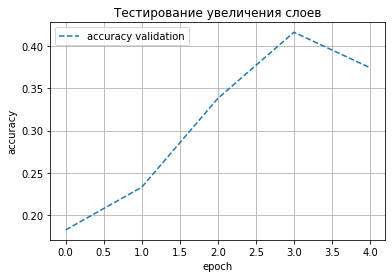

In [121]:
param_dict['num_convolution_kernels'] = 1
param_dict['add_layer'] = True

model, history = create_fit_model(param_dict)

plt.plot(history.history['val_accuracy'], '--', label = f'accuracy validation')
plt.legend()
plt.grid('On')
plt.title('Тестирование увеличения слоев')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Как и в предыдущих ДЗ, при увеличении только слоев наблюдается падение качества модели, думаю нужно увеличивать параллельно и кол-во эпох.

####Cравнить с точностью полносвязной сети для этой выборки

Для сравнения попробую для 16 ядер увеличить кол-во эпох

Не используется data augmentation
Epoch 1/10
1875/1875 [==============================] - 93s 49ms/step - loss: 1.1122 - accuracy: 0.5870 - val_loss: 0.6422 - val_accuracy: 0.7684
Epoch 2/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.6566 - accuracy: 0.7521 - val_loss: 0.5240 - val_accuracy: 0.8084
Epoch 3/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.5670 - accuracy: 0.7889 - val_loss: 0.4713 - val_accuracy: 0.8215
Epoch 4/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.5158 - accuracy: 0.8086 - val_loss: 0.4404 - val_accuracy: 0.8393
Epoch 5/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.4789 - accuracy: 0.8215 - val_loss: 0.4116 - val_accuracy: 0.8514
Epoch 6/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.4552 - accuracy: 0.8328 - val_loss: 0.4024 - val_accuracy: 0.8503
Epoch 7/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.4369 - acc

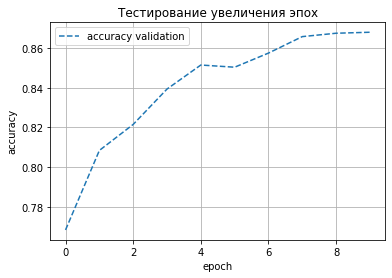

In [122]:
param_dict['num_convolution_kernels'] = 16
param_dict['add_layer'] = False
param_dict['epochs']  = 10

model, history = create_fit_model(param_dict)

plt.plot(history.history['val_accuracy'], '--', label = f'accuracy validation')
plt.legend()
plt.grid('On')
plt.title('Тестирование увеличения эпох')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Как видно увеличение кол-ва эпох более значительно влияет чем увеличение кол-ва ядер или слоев.

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [125]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_pred[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [128]:
CM = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(CM)

[[845   2  24  18   9   1  90   0  11   0]
 [  1 970   0  17   6   0   4   0   2   0]
 [ 16   1 751   6 166   0  56   0   4   0]
 [ 28  10  11 857  52   0  38   0   3   1]
 [  1   1  57  20 858   0  59   0   4   0]
 [  0   0   0   0   0 958   0  30   1  11]
 [180   2  87  15 139   0 559   0  18   0]
 [  0   0   0   0   0  14   0 952   0  34]
 [  2   1   8   3   7   2   0   5 972   0]
 [  0   0   0   0   0   2   0  40   1 957]]


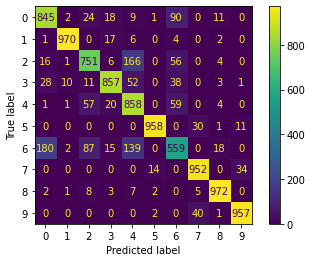

In [129]:
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=np.arange(10))

disp.plot(values_format ='.3g')
plt.show()

Рез-ты получились хуже чем в [ДЗ 2го урока](https://github.com/djo1006/Introduction_Neural_Networks/blob/main/hw_les_2.ipynb), скрин ниже. По прежнему хуже всего с 6ой картинкой, возможно нужно еще донастраивать модель для улучшения рез-та.

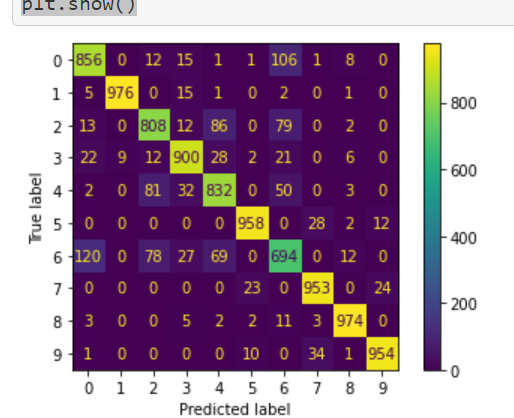